In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=affdec4cb9e209368533fcf66a7ce48a868464da4e0bc1c81b195a997f1b0f6e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import Row, SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import mean, max, min
import seaborn as sns

# **Task 1**

# New section

In [5]:
# 1. Создать спарк сессию.

spark = SparkSession.builder.getOrCreate()

In [8]:
# 2. Прочитать датасет в датафрейм.

# url = 'https://drive.google.com/file/..'
# file_id=url.split('/')[-2]
# dwn_url='https://drive.google.com/uc?id=' + file_id
# pd_df = pd.read_csv(dwn_url)

url = '/content/bestsellers with categories.csv'
df = spark.read.csv(url, header=True)
df.show()

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

In [9]:
# Используя только RDD вычислить среднюю цену всех книг, у которых рейтинг выше 4.7

df.filter(df['User Rating'] > 4.7).agg({'Price':'avg'}).show()

+-----------------+
|       avg(Price)|
+-----------------+
|10.69832402234637|
+-----------------+



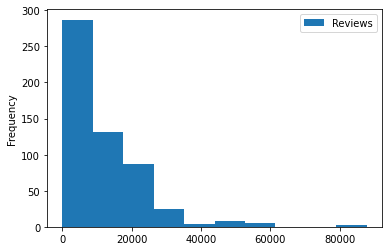

In [10]:
# Построить гистограмму распределения рецензий (столбец Reviews).

reviews = df['User Rating','Reviews'].toPandas().astype('float')

reviews.plot(y="Reviews", kind='hist')
plt.show()

In [11]:
# Построить матрицу корреляции для столбцов "User Rating", "Reviews" и "Price".

cor = df['User Rating','Reviews','Price'].toPandas().astype('float')
cor.corr(method='pearson')

,User Rating,Reviews,Price
User Rating,1.000000,-0.001729,-0.133086
Reviews,-0.001729,1.000000,-0.109182
Price,-0.133086,-0.109182,1.000000


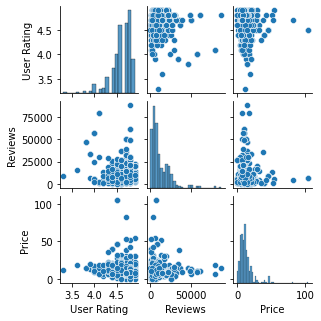

In [12]:
# Используя библиотеку seaborn построить парные графики (pairplots) столбцов "User Rating", "Reviews" и "Price".

sns.pairplot(cor, height=1.5)


# **Task 2**

In [13]:
# Найдите автора с самым высоким рейтингом.

books_new = df.withColumnRenamed('User Rating','user_rating')
books_new.createOrReplaceTempView('bestsellers')
spark.sql('SELECT DISTINCT Author, user_rating FROM bestsellers WHERE user_rating == (SELECT MAX(user_rating) FROM bestsellers)').show()

+--------------------+-----------+
|              Author|user_rating|
+--------------------+-----------+
|Emily Winfield Ma...|        4.9|
|       Mark R. Levin|        4.9|
|           Dr. Seuss|        4.9|
|Sherri Duskey Rinker|        4.9|
|  Lin-Manuel Miranda|        4.9|
|      Nathan W. Pyle|        4.9|
|       J. K. Rowling|        4.9|
|     Bill Martin Jr.|        4.9|
|         Jeff Kinney|        4.9|
|       Rush Limbaugh|        4.9|
|     Brandon Stanton|        4.9|
|          Eric Carle|        4.9|
|      Patrick Thorpe|        4.9|
|      Alice Schertle|        4.9|
|        J.K. Rowling|        4.9|
|         Sarah Young|        4.9|
|         Chip Gaines|        4.9|
|          Pete Souza|        4.9|
|          Jill Twiss|        4.9|
|          Dav Pilkey|        4.9|
+--------------------+-----------+



In [16]:
# Найдите трех авторов с самым низким рейтингом.

spark.sql('SELECT DISTINCT Author, user_rating FROM bestsellers ORDER BY user_rating LIMIT 3').show()

+------------+-----------+
|      Author|user_rating|
+------------+-----------+
|J.K. Rowling|        3.3|
|  Harper Lee|        3.6|
|   E L James|        3.8|
+------------+-----------+



In [23]:
# Определите какой автор получил наибольшее количество рецензий.

spark.sql('SELECT DISTINCT Author, Reviews FROM bestsellers WHERE Reviews == (SELECT MAX (Reviews) FROM bestsellers)').show()

+--------------+-------+
|        Author|Reviews|
+--------------+-------+
|Maurice Sendak|   9967|
+--------------+-------+



In [26]:
# Определите какой автор написал наибольшее количество книг за весь доступный в данных период.

spark.sql('SELECT Author, number FROM (SELECT Author, COUNT(Author) as number FROM bestsellers GROUP BY Author) ORDER BY number DESC LIMIT 1').show()

+-----------+------+
|     Author|number|
+-----------+------+
|Jeff Kinney|    12|
+-----------+------+



In [30]:
# Определите какая книга жанра "Fiction" имеет самый маленький рейтинг.

spark.sql("SELECT Name, Genre, user_rating FROM bestsellers WHERE Genre == 'Fiction' ORDER BY user_rating LIMIT 1").show()

+------------------+-------+-----------+
|              Name|  Genre|user_rating|
+------------------+-------+-----------+
|The Casual Vacancy|Fiction|        3.3|
+------------------+-------+-----------+



In [33]:
# Определите какая книга жанра "Non Fiction" имеет самый высокий рейтинг.

spark.sql("SELECT DISTINCT Name, Genre, user_rating FROM bestsellers WHERE Genre == 'Non Fiction' AND user_rating == (SELECT MAX (user_rating) FROM bestsellers)").show()

+--------------------+-----------+-----------+
|                Name|      Genre|user_rating|
+--------------------+-----------+-----------+
|Humans of New Yor...|Non Fiction|        4.9|
|Jesus Calling: En...|Non Fiction|        4.9|
|Obama: An Intimat...|Non Fiction|        4.9|
|  The Magnolia Story|Non Fiction|        4.9|
|Unfreedom of the ...|Non Fiction|        4.9|
|Hamilton: The Rev...|Non Fiction|        4.9|
+--------------------+-----------+-----------+



# **Task 3**

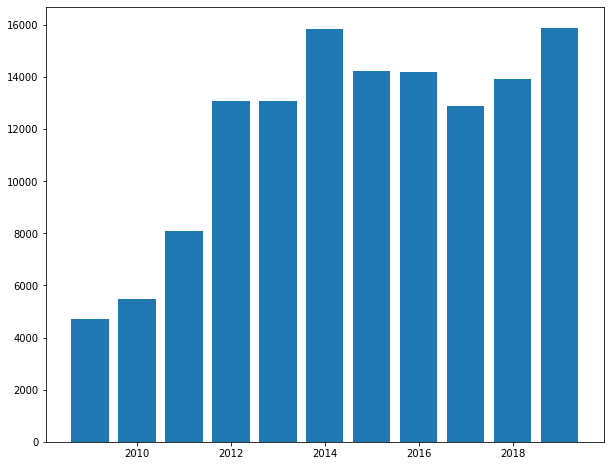

In [37]:
# Постройте гистограмму среднего количества рецензий по годам. В виде отдельной гистограммы визуализируйте количество книг жанра "Fiction" и "Non Fiction" за весь доступный период.

df_rev_avg = df.groupBy('Year').agg({'Reviews':'avg'}).toPandas()

plt.rcParams['figure.figsize'] = (10, 8)
plt.bar(df_rev_avg['Year'].astype('int'), df_rev_avg['avg(Reviews)'])
plt.show()

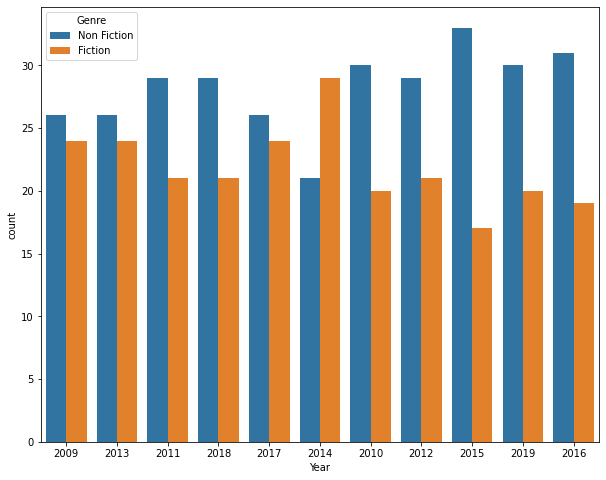

In [42]:
df_genre = df.groupBy(['Year', 'Genre']).count().toPandas()

plt.rcParams['figure.figsize'] = (10, 8)
sns.barplot(data=df_genre, x='Year', y='count', hue='Genre')
plt.show()